In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [5]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [6]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.ONE_HOUR
DEFAULT_LOOKBACK = Lookback.SIX_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_ft_{today}.csv'

In [7]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [45]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [46]:
def volume_features(df, mfi_period=14):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume']

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    df['OBV_Sign'] = df['Price Change'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    df['OBV'] = (df['OBV_Sign'] * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['A/D'] = df.groupby(['Symbol', 'Date'])['A/D'].cumsum()

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = df.groupby(['Symbol', 'Date'])['Amihud_Illiquidity'].transform('mean')

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price']

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Price Diff'] = df.groupby(['Symbol', 'Date'])['Typical Price'].diff()
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] < 0, 0)
    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum']
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['TR1'] = df['High'] - df['Low']
    df['TR2'] = (df['High'] - df['Previous Close']).abs()
    df['TR3'] = (df['Low'] - df['Previous Close']).abs()
    df['True Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

    df['Volume-Weighted_TR'] = df['True Range'] * df['Volume']

    df.drop(columns=[
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume',
        'Price Change', 'OBV_Sign', 'Raw Money Flow', 'Price Diff', 'True Range', 'Money Flow Ratio',
        'Positive Money Flow', 'Negative Money Flow', 'Positive Money Flow Sum', 'Negative Money Flow Sum', 'Previous Close',  'TR1', 'TR2', 'TR3'
    ], inplace=True)

    return df

In [47]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [8]:
volume_df = pd.read_csv(volume_df_filename)

In [9]:
volume_df.shape[0]

1566057

In [10]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,OBV,A/D,Amihud_Illiquidity,MFI,Volume-Weighted_TR
0,10000000AIDOGEUSDT,2024-03-30 22:00:00,0.005810,0.005842,0.005785,0.005817,14082800.0,1.638490e+07,0.005815,0.0,1.729467e+06,4.816182e-13,NaN,802.7196
1,10000000AIDOGEUSDT,2024-03-30 23:00:00,0.005817,0.005855,0.005797,0.005826,18687000.0,1.638490e+07,0.005821,18687000.0,1.729467e+06,4.816182e-13,NaN,1083.8460
2,10000000AIDOGEUSDT,2024-03-31 00:00:00,0.005826,0.005910,0.005826,0.005856,17636400.0,1.935145e+07,0.005864,18687000.0,-5.038971e+06,1.805443e-12,NaN,1481.4576
3,10000000AIDOGEUSDT,2024-03-31 01:00:00,0.005856,0.005925,0.005828,0.005912,19413600.0,1.935145e+07,0.005877,38100600.0,9.170983e+06,1.805443e-12,NaN,1883.1192
4,10000000AIDOGEUSDT,2024-03-31 02:00:00,0.005912,0.005956,0.005887,0.005930,12319400.0,1.935145e+07,0.005889,50420000.0,1.220620e+07,1.805443e-12,NaN,850.0386


In [11]:
unique_symbol_count = volume_df['Symbol'].nunique()
unique_symbol_count

411

In [14]:
features = ['ADV', 'VWAP', 'OBV', 'Amihud_Illiquidity', 'Volume-Weighted_TR']

n_features = len(features)

print("N Features: ", n_features)

N Features:  5


In [15]:
print("NaN values before imputation:\n", volume_df.isna().sum())

imputer = SimpleImputer(strategy='mean')

volume_df[features] = imputer.fit_transform(volume_df[features])

print("NaN values after imputation:\n", volume_df.isna().sum())

symbols = volume_df['Symbol'].unique()

symbol_sequences = []

for symbol in symbols:
    symbol_data = volume_df[volume_df['Symbol'] == symbol][features].to_numpy()
    symbol_sequences.append(symbol_data)

sequence_lengths = [len(seq) for seq in symbol_sequences]

print("Lengths of each sequence:", sequence_lengths)

max_sequence_length = max([len(seq) for seq in symbol_sequences])

print("Max seq:", max_sequence_length)

padded_sequences = [
    np.pad(seq, ((max_sequence_length - len(seq), 0), (0, 0)), 'constant', constant_values=0)
    for seq in symbol_sequences
]

pad_sequence_lengths = [len(seq) for seq in padded_sequences]

print("Lengths of each pad sequence:", pad_sequence_lengths)

symbol_sequences = np.array(padded_sequences)

scaler = StandardScaler()
n_symbols, t_time_steps, n_features = symbol_sequences.shape
symbol_sequences = symbol_sequences.reshape(-1, n_features)
normalized_sequences = scaler.fit_transform(symbol_sequences)
normalized_sequences = normalized_sequences.reshape(n_symbols, t_time_steps, n_features)

print("Shape of features:", normalized_sequences.shape)

X = torch.tensor(normalized_sequences, dtype=torch.float32)

X = X.view(X.size(0), -1)

print("X shape", X.shape)

NaN values before imputation:
 Symbol                   0
Timestamp                0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ADV                      0
VWAP                     9
OBV                      0
A/D                    265
Amihud_Illiquidity       0
MFI                   5343
Volume-Weighted_TR       0
dtype: int64
NaN values after imputation:
 Symbol                   0
Timestamp                0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ADV                      0
VWAP                     0
OBV                      0
A/D                    265
Amihud_Illiquidity       0
MFI                   5343
Volume-Weighted_TR       0
dtype: int64
Lengths of each sequence: [4320, 2577, 3198, 2028, 4320, 4320, 4320, 4320, 2363, 2844, 4320, 4320, 323, 4320, 4320, 84, 251, 4320, 4320, 4320, 4320, 4320, 43

In [16]:
def extract_embeddings(model, dataloader, device=None):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    model.eval()

    embeddings = []

    with torch.no_grad():
        for _batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)

            latent = model.get_latent(data)

            embeddings.append(latent.cpu())

    embeddings = torch.vstack(embeddings)

    return embeddings

In [18]:
from notebooks.models import AutoEncoder
from notebooks.train import SnapshotManager, EarlyStop, CheckPoint, CommonTrainer

feature_dim = max_sequence_length * n_features
latent_dim = 16
patience = 12
epochs = 900
lr=1e-7
batch_size = 4
n_snapshots = 3

print("Feature DIM: ", feature_dim)

model = AutoEncoder(feature_dim=feature_dim, latent_dim=latent_dim)
dataset = torch.utils.data.TensorDataset(X)
dataloader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=batch_size, shuffle=True)

snapshot_manager = SnapshotManager(model, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=5)
checkpoint = CheckPoint(snapshot_manager=snapshot_manager, snapshot_interval=5)

trainer = CommonTrainer(model, dataloader, early_stop, checkpoint, epochs, lr)

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

trainer.train()

Feature DIM:  21600
Loaded snapshot: snapshots/AutoEncoder_epoch_515_improved.pth
Epoch [1/900], Train Loss: 0.26396209
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Epoch [2/900], Train Loss: 0.26420412
Saved periodic snapshot: snapshots/AutoEncoder_epoch_2_periodic.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_515_improved.pth
Epoch [3/900], Train Loss: 0.26360588
Saved improved snapshot: snapshots/AutoEncoder_epoch_3_improved.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_516_periodic.pth
Epoch [4/900], Train Loss: 0.26340558
Saved improved snapshot: snapshots/AutoEncoder_epoch_4_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_3_improved.pth
Epoch [5/900], Train Loss: 0.26263997
Saved improved snapshot: snapshots/AutoEncoder_epoch_5_improved.pth
Saved periodic snapshot: snapshots/AutoEncoder_epoch_5_periodic.pth
Removed excess snapshot: snapsho

In [84]:
snapshot_manager.load_latest()

embeddings = extract_embeddings(model, dataloader)

print("Embeddings shape:", embeddings.shape)

embeddings_np = embeddings.numpy()

np.save(emb_filename, embeddings_np)

Loaded snapshot: snapshots/Autoencoder_epoch_8_improved.pth
Embeddings shape: torch.Size([411, 16])


In [85]:
n_clusters = 3

In [86]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(embeddings_np)

k_cluster_labels = kmeans.labels_

print("KMeans cluster labels", len(k_cluster_labels))

KMeans cluster labels 411


In [87]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)
dbscan_labels = dbscan.fit_predict(embeddings_np)

print("DBSCAN cluster labels:", len(dbscan_labels))

DBSCAN cluster labels: 411


In [88]:
embedding_list = [embedding.tolist() for embedding in embeddings]

df = pd.DataFrame({
    'symbol': symbols,
    'embedding': embedding_list,
    'k_cluster': k_cluster_labels,
    'dbscan_cluster': dbscan_labels
})

df['embedding'] = df['embedding'].apply(np.array)

df.head()


,symbol,embedding,k_cluster,dbscan_cluster
0,10000000AIDOGEUSDT,"[0.38264718651771545, -0.23757106065750122, -0...",2,0
1,1000000BABYDOGEUSDT,"[0.3966783881187439, -0.21905681490898132, -0....",2,0
2,1000000MOGUSDT,"[0.39383164048194885, -0.223589688539505, -0.1...",2,0
3,1000000PEIPEIUSDT,"[0.39297711849212646, -0.22418014705181122, -0...",2,0
4,10000COQUSDT,"[0.3906477987766266, -0.23023618757724762, -0....",2,0


In [89]:
df[df['symbol'] == 'OMGUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
260,OMGUSDT,"[0.3916151225566864, -0.21499502658843994, -0....",2,0


In [90]:
df[df['symbol'] == 'BTCUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
88,BTCUSDT,"[0.438035786151886, -0.1774425059556961, -0.10...",2,0


In [91]:
df[df['symbol'] == 'SOLUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
332,SOLUSDT,"[0.395602822303772, -0.18997566401958466, -0.1...",2,0


In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
reduced_embeddings = pca.fit_transform(embeddings_np)

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(embeddings_np)

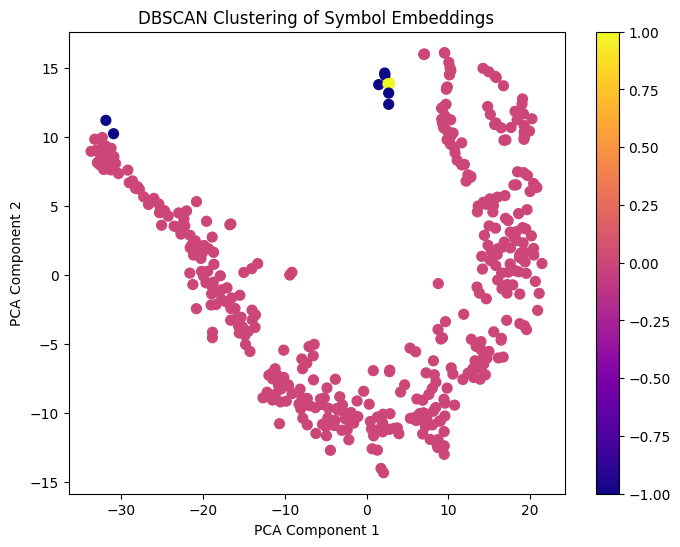

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.colorbar()
plt.title('DBSCAN Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

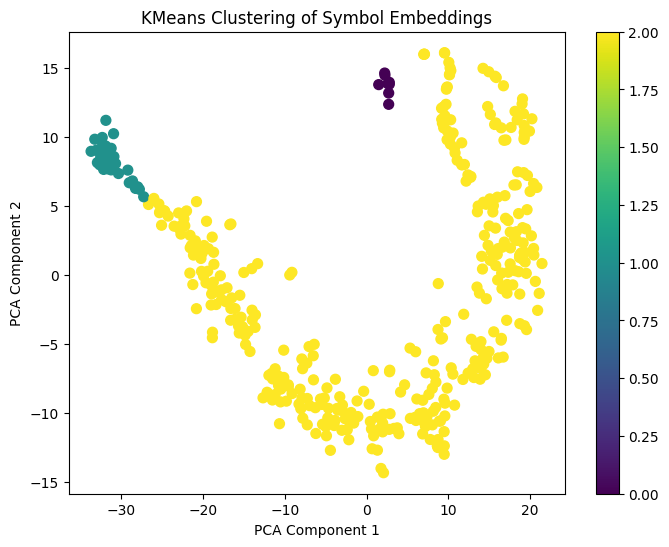

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=k_cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('KMeans Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()